## Titanic Data Exploration

In this project we will investigate the data regarding the Titanic tragedy, aiming to reveal which factors made passengers more likely to survive.


## Question
### Which factors made passengers more likely to survive to the Titanic tragedy?

First, we need to load our libraries and data

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image  
import pydotplus
from sklearn import tree

%config IPCompleter.greedy=True
%matplotlib inline


In [12]:
titanicData = pd.read_csv('titanic-data.csv')
print titanicData.Sex.value_counts()

#titanicData = titanicData.dropna()
print titanicData.Sex.value_counts()

print titanicData.head()


male      577
female    314
Name: Sex, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3   

Ok, everything sounds good but we need to clarify what each variable mean:
   * Passenger Id: exclusive identification of the passenger. Should not have duplicates;
   * Survived: Whether the passenger survived(1) or not(0);
   * Pclass: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class);
   * Name: Name of passenger;
   * Sex: Sex of the passenger;
   * Age: Age of the passenger;
   * SibSp: Number of siblings and spouses of the passenger aboard;
   * Parch: Number of parents and children of the passenger aboard;
   * Ticket: Ticket number of the passenger;
   * Fare: Fare paid by the passenger;
   * Cabin: Cabin number of the passenger;
   * Embarked: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton).

# Data Wrangling

From the available variables, Passenger ID should not be relevant for our analysis as it seems to be only an alternative to the name itself. The name on the other hand could be useful if we either analyzed the strings to filter for titles like Dr or Ms or had a second database with more information and use the names to link both. As for this analysis, both the name and passengerId will be supressed. 

In [13]:
titanicData.drop('PassengerId', axis=1, inplace=True)
titanicData.drop('Name', axis=1, inplace=True)


On the other hand, the sex variable is probably important but needs to be converted from string to some other format easier to use, such as replacing male with 0 and female with 1.

In [14]:
titanicData.Sex.replace('male', 0, inplace=True)
titanicData.Sex.replace('female', 1, inplace=True)

The embarked variable has a similar issue, which we can deal with by converting the strings related to the ports to actual numbers

In [15]:
titanicData.Embarked.replace('C', 1, inplace=True, regex=True)
titanicData.Embarked.replace('Q', 2, inplace=True)
titanicData.Embarked.replace('S', 3, inplace=True)

Both ticket and cabin variables have some letters with the strings, which should be removed to allow easier processing.

In [16]:
titanicData.Ticket.replace('[A-Z]', '', inplace=True, regex=True)
titanicData.Ticket.replace('^[0-9]+\\s[0-9]*\\s*[0-9]*\\s*', '', inplace=True, regex=True)
titanicData.Cabin.replace('[A-Z]', '', inplace=True, regex=True)
titanicData.Cabin.replace('^[0-9]+\\s[0-9]*\\s*[0-9]*\\s*', '', inplace=True, regex=True)

Now we have to see of there are cells without an actual value and deal with them.

In [17]:
titanicData.isnull().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Fare          0
Ticket        0
Parch         0
SibSp         0
Sex           0
Pclass        0
Survived      0
dtype: int64

Ok, for cabins without value, there isn't much to be done as we don't have the historical records to fill this information and, as there are a total of 891 cases and 864 of them doesn't have a cabin, the cabin feature can be dropped withou much loss of information. As for the age, there are 177 occurences of Not a number. For these we could add the average age hoping to regain some of the lost information.

In [18]:
titanicData = titanicData.drop('Cabin', axis=1)
titanicData.Age.fillna(titanicData.Age.mean(), inplace=True)
titanicData.Embarked.fillna('1', inplace=True)
titanicData.isnull().sum().sort_values(ascending=False)

Embarked    0
Fare        0
Ticket      0
Parch       0
SibSp       0
Age         0
Sex         0
Pclass      0
Survived    0
dtype: int64

# Data Exploration

Before we start exploring the data, it is good to remember the question we want to answer: Which factors made passengers more likely to survive to the Titanic tragedy?

With this in mind, we can use a somewhat unconventional approach and start by analyzing the results of a Decision tree model applied to the whole set. This model wouldn't be useful for correctly predicting new samples as it would most likely be overfitted but it should provide a good and easy to understand overall on the factors which led people to survive.

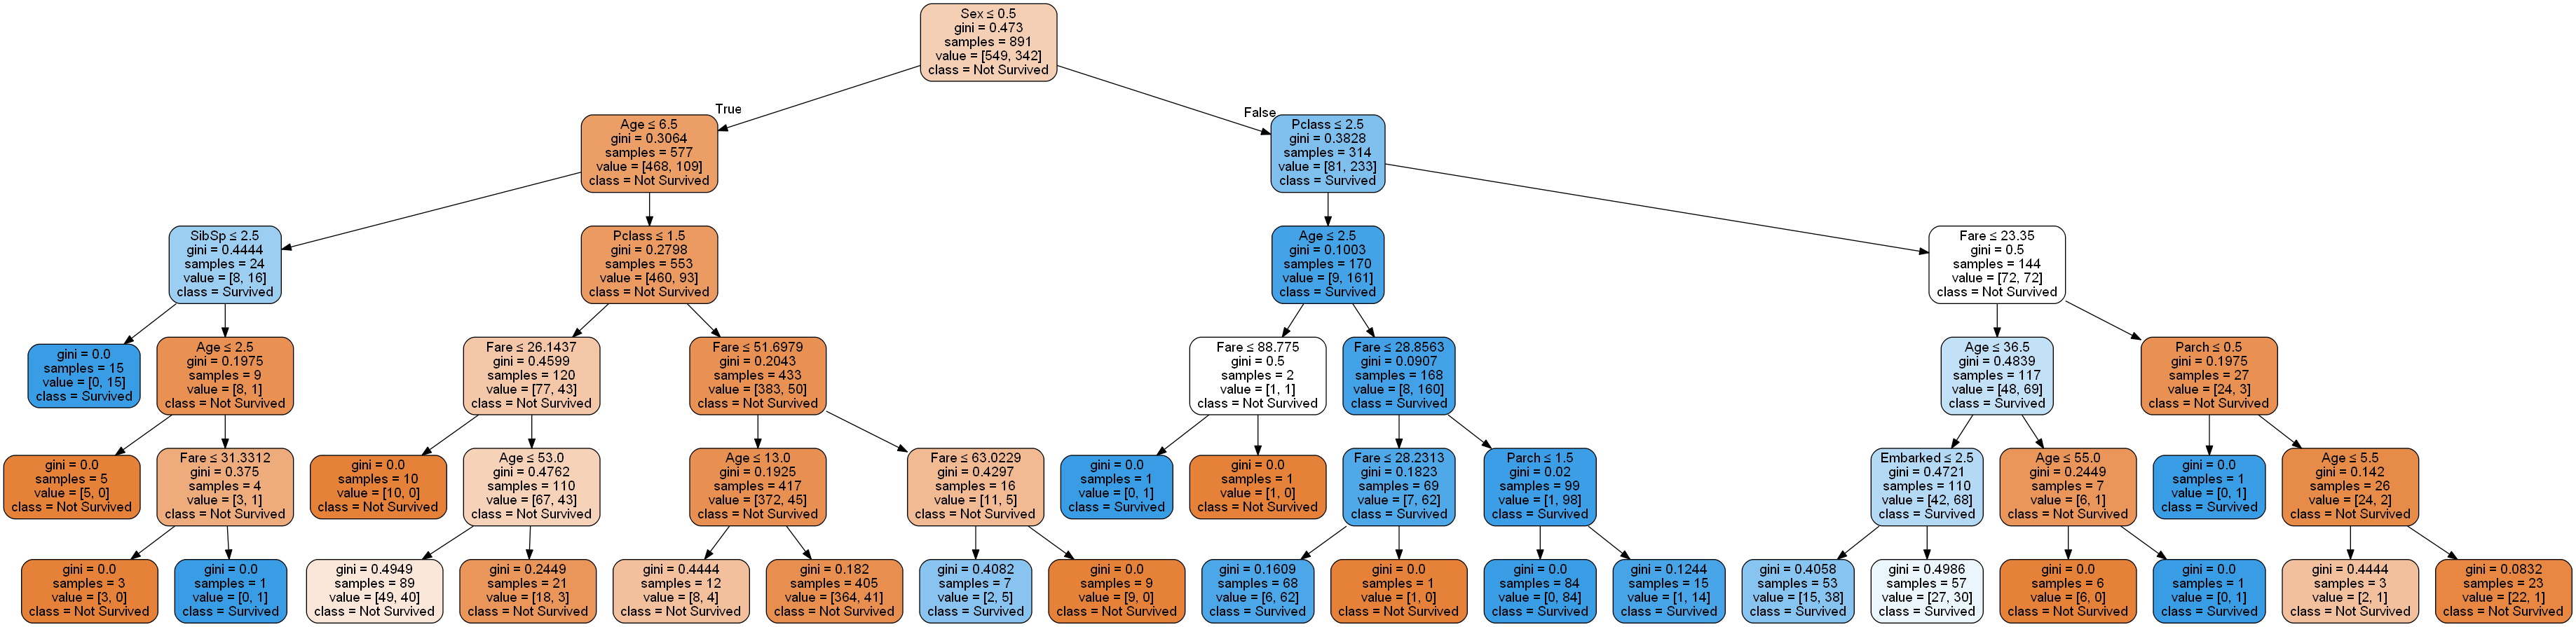

In [21]:
classifier = tree.DecisionTreeClassifier(max_depth=5)
titanicDataResults = titanicData['Survived']
titanicDataFeatures = titanicData.drop('Survived', axis=1)
#titanicDataFeatures = titanicDataFeatures.drop('Cabin', axis=1)
titanicDataFeatures = titanicDataFeatures.drop('Ticket', axis=1)
classifier = classifier.fit(titanicDataFeatures , titanicDataResults)


dot_data = tree.export_graphviz(classifier, out_file=None, 
                         feature_names=titanicDataFeatures.columns.values,  
                         class_names=['Not Survived', 'Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Good, our classifier mapped the most important factors by splitting the set based on them. First, there is a split related to the Sex, as women are considered on the right and men on the left. Then, comes the socio-economic class, followed by fare and age. Additionally, the number of siblings or parents or port of embark doesn't seem to have much relevance, as they are responsible for separation on just a few cases.

To evaluate and explain better what was seen on the decision tree clasifier result, we can buil and analyze a confusion matrix, which shows the correlation between the variables.

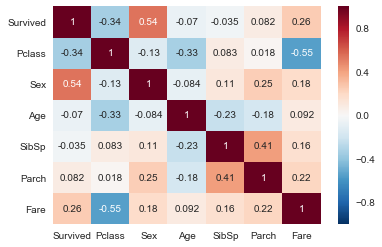

In [42]:
ax = sns.heatmap(titanicData.corr(), annot=True)

Great, by looking at the first colunm we can see that the most important factor for survivability was the sex (women tend to survive more), followed by the socio-economic class( people from upper classes, represented by lower numbers, tend to live more, as the correlation is negative) and by the fare paid ( survivability linked to paying a higher fare). Additionally, Age, number of parents and number of siblings don't have much influence on the survivability rate.

To confirm the relation of sex with survivability, lets check the percentage of women who survived versus men who survived.

In [76]:
menData = titanicData[titanicData.Sex == 0]
womenData = titanicData[titanicData.Sex == 1]
menSurvivabilityRate = menData.Survived.value_counts()[1]/ float(menData.Survived.value_counts()[1] + menData.Survived.value_counts()[0])
womenSurvivabilityRate = womenData.Survived.value_counts()[1]/ float(womenData.Survived.value_counts()[1] + womenData.Survived.value_counts()[0])
print 'Number of women:{0} \n Number of men: {1} \n Survivability for women: {2:.2f}%, \n \t\t men: {3:.2f}%'.format(len(womenData), len(menData), womenSurvivabilityRate, menSurvivabilityRate)

Number of women:314 
 Number of men: 577 
 Survivability for women: 0.74%, 
 		 men: 0.19%


We can see that although there were much less women than men on the ship, those women who were there tended to survive more than the men.

Now, we can check for the economical class.

In [82]:
upperClass = titanicData[titanicData.Pclass == 1]
upperClassSurv = len(upperClass[upperClass.Survived == 1]) / float(len(upperClass))
middleClass = titanicData[titanicData.Pclass == 2]
middleClassSurv = len(middleClass[middleClass.Survived == 1]) / float(len(middleClass))
lowerClass = titanicData[titanicData.Pclass == 3]
lowerClassSurv = len(lowerClass[lowerClass.Survived == 1]) / float(len(lowerClass))
print 'Survivability for upper class: {0:.2f}; \n\t\t middle class: {1:.2f}; \n\t\t lower class: {2:.2f}.'.format(upperClassSurv, middleClassSurv, lowerClassSurv)

Survivability for upper class: 0.63; 
		 middle class: 0.47; 
		 lower class: 0.24.


As expected, the percentage of people from upper classes who survived s much greater than middle or lower classes.

# Conclusion

This analysis allows us to conclude that rich women were the group most likely to survive to the Titanic tragedy. The other factors available on the dataset didn't have as much relevant as these ones. This result could be somewhat expected as people from the higher classes could imposed themselves as being more important than others for their richness. Additionally, women at that time were considered more fragile and it was a men's duty to protect them, which could induce men to allow women to escape first. 
Finally, it was surprising that the number of siblings and parents did not have much effect on the survival.